In [1]:
# using Pkg
# Pkg.add("HCubature")
# Pkg.add("QuadGK")

In [58]:
using LinearAlgebra
using QuadGK
using Plots

In [4]:
maxevals = 10^2;

In [5]:
quadgk((x)->x^2,0,1; maxevals)

(0.3333333333333333, 0.0)

$$
\pi Q = 0
$$

$$
Q^\top \pi^\top = 0 
$$

$$
{\mathbf 1}^\top \pi^\top = 1
$$

In [6]:
Q = [-2 1.0 1;
      1 -2 1;
      2 2 -4]

D = [1 1 0.5;
     0.5 0 1;
      2 1 0];

In [7]:
b = vcat(zeros(2), ones(1));
A = vcat(Q'[1:2,:], ones(3)')

3×3 Matrix{Float64}:
 -2.0   1.0  2.0
  1.0  -2.0  2.0
  1.0   1.0  1.0

In [8]:
π_vec = round.(A \ b, digits=2)'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 0.4  0.4  0.2

In [9]:
π_vec*Q

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0  0.0

In [10]:
one_vec = ones(3);

$$
M_3(t)  = 6 \int_0^t \int_0^{u_3} 
\underbrace{\int_0^{u_2} 
\underbrace{e^{Q u_1} D e^{Q (u_2 - u_1)} D e^{Q (u_3 - u_2)} D e^{Q (t - u_3)}}_{I_0(u_1,u_2,u_3)} \, du_1}_{I_1} \, du_2 \, du_3.
$$

In [11]:
maxevals = 10^3;
I0(u1,u2,u3,t) = exp(Q*u1)*D*exp(Q*(u2-u1))*D*exp(Q*(u3-u2))*D*exp(Q*(t-u3))
I1(u2,u3,t) = quadgk((u1)->I0(u1,u2,u3,t), 0, u2; maxevals = maxevals)[1]
I2(u3,t) = quadgk((u2)->I1(u2,u3,t), 0, u3; maxevals = maxevals)[1]
I3(t) = quadgk((u3)->I2(u3,t),0,t; maxevals = maxevals)[1]
M3(t) = 6*I3(t)
third_moment(t) = π_vec*M3(t)*one_vec

third_moment (generic function with 1 method)

In [12]:
@time third_moment(1.1)

 14.855431 seconds (186.76 M allocations: 8.690 GiB, 4.61% gc time, 99.88% compilation time)


15.077745680967237

#### Also doing second moment - just to be sure

$$
M_2(t)  = 2 \int_0^t \int_0^{u_2} e^{Q u_1} D e^{Q (u_2 - u_1)} D e^{Q (t - u_2)} \, du_1 \, du_2, \\
$$

In [96]:
maxevals = 10^3;
I0_2(u1,u2,t) = exp(Q*u1)*D*exp(Q*(u2-u1))*D*exp(Q*(t-u2))
I1_2(u2,t) = quadgk((u1)->I0_2(u1,u2,t), 0, u2; maxevals = maxevals)[1]
I2_2(t) = quadgk((u2)->I1_2(u2,t), 0, t; maxevals = maxevals)[1]
M2(t) = 2*I2_2(t)
second_moment(t) = π_vec*M2(t)*one_vec

second_moment (generic function with 1 method)

In [97]:
@time second_moment(1.1)

  0.143655 seconds (1.32 M allocations: 66.120 MiB, 5.80% gc time, 99.44% compilation time)


6.017913784781134

## Deviation Matrices

In [15]:
Q⁻ = inv(one_vec*π_vec - Q) #fundamental matrix

3×3 Matrix{Float64}:
 0.586667  0.253333  0.16
 0.253333  0.586667  0.16
 0.32      0.32      0.36

In [16]:
Dʰ = Q⁻-one_vec*π_vec

3×3 Matrix{Float64}:
  0.186667  -0.146667  -0.04
 -0.146667   0.186667  -0.04
 -0.08      -0.08       0.16

In [17]:
Dʰ*one_vec #should be 0

3-element Vector{Float64}:
 -1.1102230246251565e-16
 -2.498001805406602e-16
 -2.7755575615628914e-16

In [18]:
π_vec*Dʰ#should be 0

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 -4.94604e-17  -1.02196e-16  -5.65104e-17

In [19]:
Dʰₜ(t) = Dʰ*(I-exp(Q*t))

Dʰₜ (generic function with 1 method)

In [20]:
numerical_check_trans_deviation(t) = quadgk((u)->(exp(Q*u) - one_vec*π_vec), 0,t)[1]

numerical_check_trans_deviation (generic function with 1 method)

In [21]:
numerical_check_trans_deviation(1.3)

3×3 Matrix{Float64}:
  0.183263   -0.143323   -0.0399399
 -0.143323    0.183263   -0.0399399
 -0.0798797  -0.0798797   0.159759

In [22]:
Dʰₜ(1.3)

3×3 Matrix{Float64}:
  0.183263   -0.143323   -0.0399399
 -0.143323    0.183263   -0.0399399
 -0.0798797  -0.0798797   0.159759

### First moment and its integral

$$
M_1(t) = \int_0^t e^{Q u_1} D e^{Q (t - u_1)} \, du_1
$$


In [25]:
m1_integrand(u1,t) = exp(Q*u1)*D*exp(Q*(t-u1))
m1(t) = quadgk((u1)->m1_integrand(u1,t), 0, t, maxevals = maxevals)[1];

In [26]:
m1(2.3)

3×3 Matrix{Float64}:
 2.12496  1.99241  1.06913
 1.99216  1.85846  1.00288
 2.13876  2.00526  1.07598

In [29]:
integral_m1(t) = quadgk(m1, 0, t, maxevals = maxevals)[1];

In [30]:
integral_m1(2.3)

3×3 Matrix{Float64}:
 2.51174  2.287    1.26409
 2.25375  1.97391  1.17951
 2.59468  2.29251  1.2678

### Checking our expressions

In [31]:
πD1 = π_vec*D*one_vec

2.2

In [32]:
πD = π_vec*D

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  0.6  0.6

In [33]:
D1 = D*one_vec

3-element Vector{Float64}:
 2.5
 1.5
 3.0

##### Second moment

$$
\boldsymbol{\pi} M_2(t) \mathbf{1} =
 (\boldsymbol{\pi} D  \mathbf{1} )^2 t^2 
 +  2\boldsymbol{\pi} D D^{\sharp}_{Q}  D \mathbf{1}t
 -  2 \boldsymbol{\pi} D D^{\sharp}_{Q}  D^{\sharp}_{Q}(t)
 D \mathbf{1}
$$

In [139]:
our_second_moment(t) = πD1^2*t^2 + 2πD*Dʰ*D1*t - 2*π_vec*D*Dʰ*Dʰₜ(t)*D1;

In [140]:
our_second_moment(2.3)

26.00026714235093

In [141]:
second_moment(2.3)

26.000267142350936

In [131]:
our_second_moment(100)/100^2

4.841967608888889

In [132]:
second_moment(100)/100^2

4.841967608888879

In [133]:
(our_second_moment(100) - πD1^2*100^2) /100

0.19676088888882076

In [134]:
(second_moment(100) - πD1^2*100^2) /100

0.1967608888878749

In [135]:
(our_second_moment(100) - πD1^2*100^2 - 2πD*Dʰ*D1*100)

-0.05724444445107579

In [136]:
(second_moment(100) - πD1^2*100^2 - 2πD*Dʰ*D1*100)

-0.05724444454566324

In [91]:
t_range = 1:0.5:10
ours = [our_second_moment(t) for t in t_range]
numerical = [second_moment(t) for t in t_range]
for (i,t) in enumerate(t_range)
    # @show t, ours[i], numerical[i], ours[i]- numerical[i]
    @show t, ours[i]- numerical[i]

end

(t, ours[i] - numerical[i]) = (1.0, 0.054945440128726375)
(t, ours[i] - numerical[i]) = (1.5, 0.056743631785028725)
(t, ours[i] - numerical[i]) = (2.0, 0.05713369656193379)
(t, ours[i] - numerical[i]) = (2.5, 0.05721981521571351)
(t, ours[i] - numerical[i]) = (3.0, 0.05723895564871384)
(t, ours[i] - numerical[i]) = (3.5, 0.05724322028083151)
(t, ours[i] - numerical[i]) = (4.0, 0.05724417134196358)
(t, ours[i] - numerical[i]) = (4.5, 0.05724438351076344)
(t, ours[i] - numerical[i]) = (5.0, 0.057244430848584216)
(t, ours[i] - numerical[i]) = (5.5, 0.057244441410830404)
(t, ours[i] - numerical[i]) = (6.0, 0.057244443767615394)
(t, ours[i] - numerical[i]) = (6.5, 0.05724444429344544)
(t, ours[i] - numerical[i]) = (7.0, 0.05724444441077026)
(t, ours[i] - numerical[i]) = (7.5, 0.05724444443694665)
(t, ours[i] - numerical[i]) = (8.0, 0.05724444444280152)
(t, ours[i] - numerical[i]) = (8.5, 0.05724444444410892)
(t, ours[i] - numerical[i]) = (9.0, 0.05724444444444998)
(t, ours[i] - numerical[i]

##### Third moment

$$
{\pi} M_3(t) \mathbf{1}= 
({\pi} D\mathbf{1})^3
t^3
+
6{\pi} D \mathbf{1} {\pi} D D_Q^\sharp D 
\mathbf{1}
t^2
+
6{\pi} D
\big(
 \mathbf{1} {\pi} D (D_Q^\sharp)^2
+
 D_Q^\sharp D D_Q^\sharp  
\big)
D \mathbf{1}
t
-
6{\pi} D
\big(  \mathbf{1} {\pi} D (D_Q^\sharp)^2 
+
 D_Q^\sharp D D_Q^\sharp 
 \big)
 D_Q^\sharp(t)
 D \mathbf{1}
- 
 6{\pi} D D^\sharp_Q
 \int_0^t M_1(u) du D \mathbf{1}
$$

In [142]:
our_third_moment(t) = (πD1^3*t^3 
                        + 6πD1*πD*D*Dʰ*D1*t^2 
                        + 6πD*(one_vec*πD*Dʰ^2  + Dʰ*D*Dʰ)*D1*t
                        - 6πD*(one_vec*πD*Dʰ^2  + Dʰ*D*Dʰ)*Dʰₜ(t)*D1
                        - 6πD*Dʰ*integral_m1(t)*D1
                        )

our_third_moment (generic function with 1 method)

In [165]:
our_third_moment(t)/t^3

10.860875747555559

In [166]:
third_moment(t)/t^3

10.769948828444443

In [92]:
t_range = 1:0.5:10
ours = [our_third_moment(t) for t in t_range]
numerical = [third_moment(t) for t in t_range]
for (i,t) in enumerate(t_range)
    # @show t, ours[i], numerical[i]
    @show t, ours[i] - numerical[i]
end

(t, ours[i] - numerical[i]) = (1.0, 1.3722429376302472)
(t, ours[i] - numerical[i]) = (1.5, 2.7872835602611588)
(t, ours[i] - numerical[i]) = (2.0, 4.626392045691134)
(t, ours[i] - numerical[i]) = (2.5, 6.884827395763324)
(t, ours[i] - numerical[i]) = (3.0, 9.561556588254177)
(t, ours[i] - numerical[i]) = (3.5, 12.656351163531838)
(t, ours[i] - numerical[i]) = (4.0, 16.169160312715462)
(t, ours[i] - numerical[i]) = (4.5, 20.099972712548606)
(t, ours[i] - numerical[i]) = (5.0, 24.44878583759919)
(t, ours[i] - numerical[i]) = (5.5, 29.21559912445923)
(t, ours[i] - numerical[i]) = (6.0, 34.400412447422696)
(t, ours[i] - numerical[i]) = (6.5, 40.00322577844281)
(t, ours[i] - numerical[i]) = (7.0, 46.024039111258844)
(t, ours[i] - numerical[i]) = (7.5, 52.46285244447972)
(t, ours[i] - numerical[i]) = (8.0, 59.31966577778621)
(t, ours[i] - numerical[i]) = (8.5, 66.5944791111142)
(t, ours[i] - numerical[i]) = (9.0, 74.28729244445276)
(t, ours[i] - numerical[i]) = (9.5, 82.39810577779281)
(t, 

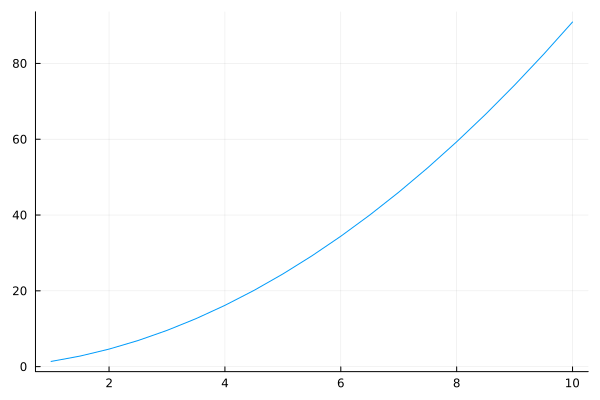

In [93]:
plot(t_range, ours -numerical, label = false)#, label=["ours" "numerical"])

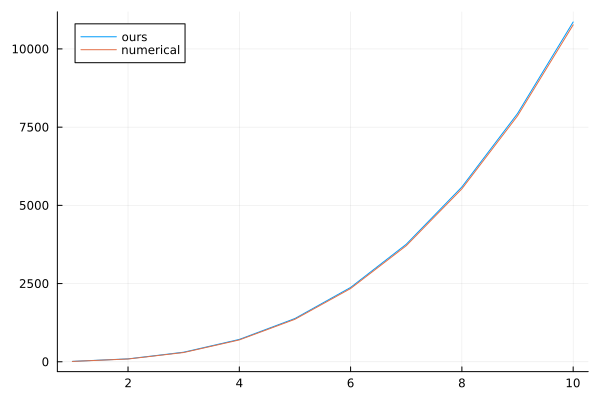

In [70]:
plot(t_range, hcat(ours,numerical), label=["ours" "numerical"])

In [75]:
plot(numerical ./ t_range.^3, label=false)

LoadError: DimensionMismatch: arrays could not be broadcast to a common size: a has axes Base.OneTo(10) and b has axes Base.OneTo(39)